# Transformers and Attention

Machine Learning Fundamentals for Economists

Jesse Perla (University of British Columbia)

# Overview

## Summary

-   Describe “attention” with function approximation and relate to
    kernels and similarity
-   Describe transformers, the architecture that makes LLMs possible
-   Give intuition on how/when transformers can work
-   Describe it more generally as a tool for sequential and set-based
    data (e.g., graphs, images)

## References

-   The transformer model is complicated and uses some building blocks
    we haven’t formally introduced
-   These notes are a bare-bones introduction.
-   Melissa Dell’s [Course](https://econdl.github.io/) has plenty of
    details:
    -   [Sequential
        Data](https://econdl.github.io/intro/2023/01/20/lecture3.html),
        [Transformers](https://econdl.github.io/intro/2023/01/21/lecture4.html)
        and [More
        Transformers](https://econdl.github.io/intro/2023/01/22/lecture5.html)
-   [ProbML Book 1](https://probml.github.io/pml-book/book1.html) and
    [ProbML Book 2](https://probml.github.io/pml-book/book2.html)

## Packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import jax
import jax.numpy as jnp
from flax import nnx
torch.manual_seed(42)

# Attention

## Reminder: Kernel Regression

-   Recall in the Kernels/GP lecture we discussed how we can define a
    kernel to do pairwise comparisons of two inputs from a set of data
    $X = \{x_1, x_2, \ldots, x_n\}$ with outputs
    $Y = \{y_1, y_2, \ldots, y_n\}$.
    -   $\mathcal{K}(x_i, x_j)$ is a measure of similarity between $x_i$
        and $x_j$.
    -   Then, for a new $x$, we could define a vector of similarity
        scores, $\alpha(x) \equiv [\mathcal{K}(x, x_i)]_{i=1}^n$
    -   And “predict” a $y(x)$ as a weighted sum of the $y_i$’s $$
        y(x) \approx \sum_{i=1}^n \mathcal{K}(x, x_i) y_i = \alpha(x) \cdot Y
        $$
-   Non-parametric, with potentially infinite-dimensional feature spaces

## Attention as a Fuzzy Look-up Table

-   We can think of kernel regression as a non-parametric model of
    attention (see [ProbML Book 1 Section
    15.4.2](https://probml.github.io/pml-book/book1.html))
-   A fuzzy look-up table with three ingredients:
    1.  **Query** $x$: the input you want to look up
    2.  **Keys** $x_1, \ldots, x_n$: the stored entries you compare
        against
    3.  **Values** $y_1, \ldots, y_n$: the output associated with each
        key
-   The look-up is “fuzzy” because instead of returning a single exact
    match:
    -   Score each key by similarity: $\alpha_i(x) = x \cdot x_i$ (dot
        product)
    -   Normalize to probabilities:
        $\alpha_i(x) / \sum_{i'} \alpha_{i'}(x)$
    -   Return the weighted average of values:
        $\sum_i \alpha_i(x)\, y_i$

## Parametric Version

-   Taking that inspiration, we want to define a version of this which
    is parametric (i.e., it will not require saving all the data in
    memory) and is differentiable
    -   To be parametric, replace the fixed kernels based on the data
        with a parametric form as a learned embedding
    -   In order to be differentiable, we want to replace a fixed lookup
        table with a probabilistic one
-   Kernel Regressions evaluated on new $\{x_1, \ldots, x_n\}$ required
    pairwise comparison within that set, and across all previous data.
    -   Parametric versions can just compare the new $x$ to each other
        pairwise using the embedding
-   See [ProbML Book 1 Section
    15.4](https://probml.github.io/pml-book/book1.html) and [ProbML Book
    2 Section 16.2.7](https://probml.github.io/pml-book/book2.html) for
    more

## From Token IDs to Vectors

-   Attention operates on continuous vectors, but LLM inputs are
    discrete **token IDs** $c \in \{1,\ldots,C\}$ where $C$ is the
    vocabulary size
-   Represent each token as a **one-hot** (i.e., dummy variable) vector
    $e_c \in \{0,1\}^{C}$, with a $1$ in position $c$
-   A learned **token-embedding matrix**
    $W_E \in {\mathbb{R}}^{C \times h}$ maps this to a dense vector $$
    x = e_c^\top W_E \in {\mathbb{R}}^h
    $$
    -   This is just a lookup of row $c$ of $W_E$ — but writing it as a
        matrix multiply makes it differentiable and end-to-end trainable
-   $W_E$ is learned jointly with all other parameters (attention
    weights, etc.)
-   Positional encodings are added to $x$ so the model knows token order
    (discussed later)
-   Recall from the [Embeddings lecture](embeddings_nlp_llm.qmd):
    tokenizers split text → token IDs; this matrix turns those IDs into
    the vectors that attention consumes

## Mapping to an Embedding Space

-   Starting from token embeddings $x \in {\mathbb{R}}^h$, learn three
    linear projections:
    1.  **Query**: $q = x W_Q$ for $W_Q \in {\mathbb{R}}^{h \times d}$
    2.  **Key**: $k = x W_K$ for $W_K \in {\mathbb{R}}^{h \times d}$
    3.  **Value**: $v = x W_V$ for $W_V \in {\mathbb{R}}^{h \times v}$
-   Queries and keys live in the same $d$-dimensional space (so their
    dot product is defined); values can have a different dimension $v$
-   For $n$ input tokens, stack rows into matrices
    $Q \in {\mathbb{R}}^{n \times d}$,
    $K \in {\mathbb{R}}^{n \times d}$, and
    $V \in {\mathbb{R}}^{n \times v}$

## Attention for a Single “Query”

-   Given a $q$, the attention is $$
    \begin{aligned}
    \text{Attn}(q, K, V) &\equiv \sum_{i=1}^n \alpha_i(q, K)\cdot V_i\\
      \alpha_i(q, K) &\equiv \frac{\exp(a(q, K_i))}{\sum_{j=1}^n \exp(a(q, K_j))} && \small\text{(attention weight on key } i\text{)}\\
      a(q, k) &\equiv q \cdot k/\sqrt{d} && \small\text{(similarity score)}
    \end{aligned}
    $$
-   The output is a **weighted combination of values**: each value $V_i$
    contributes in proportion to how well its key matches the query
-   The weights $\alpha_i$ are a softmax over similarity scores — so
    they are non-negative and sum to 1

## Attention Layer

-   Typically we are calculating the attention for a sequence of $n$
    embedded inputs
-   Use $W_Q$ to embed inputs, $Q \in {\mathbb{R}}^{n \times d}$, then
    $$
    Z = \text{Attn}(Q, K, V) = \mathrm{softmax}\left(\frac{Q K^{\top}}{\sqrt{d}}\right)V \in {\mathbb{R}}^{n \times v}
    $$
    -   The parameters to “learn” are just the embeddings, $W_Q, W_K$
        and potentially $W_V$
-   Why $1/\sqrt{d}$? If entries of $q, k$ have unit variance,
    $q \cdot k$ has variance $\approx d$
    -   Without rescaling, softmax collapses toward putting all weight
        on one key — deterministic rather than fuzzy lookup
    -   Mechanically changes the “temperature” of softmax. See the
        [Embeddings lecture](embeddings_nlp_llm.qmd)

## Scaled Dot-Product Attention in Code

In [2]:
C, d, n = 3, 4, 3  # vocab size, embedding dim, sequence length

# One-hot encoding → embedding
token_ids = torch.tensor([0, 2, 1])
one_hot = F.one_hot(token_ids, num_classes=C).float()
W_E = torch.randn(C, d)
X = one_hot @ W_E  # (n, d) embedded tokens

# Learned projection matrices
W_Q = torch.randn(d, d)
W_K = torch.randn(d, d)
W_V = torch.randn(d, d)

Q = X @ W_Q # broadcasts to all tokens
K = X @ W_K
V = X @ W_V

# Scaled dot-product attention (manual)
scores = (Q @ K.T) / d**0.5
weights = torch.softmax(scores, dim=-1)
output = weights @ V

print("Attention weights (each row sums to 1):")
print(weights.detach().numpy().round(3))
print("Output:")
print(output.detach().numpy().round(3))

Attention weights (each row sums to 1):
[[0.283 0.313 0.404]
 [0.142 0.172 0.687]
 [0.756 0.242 0.001]]
Output:
[[-1.087  1.036 -1.564  0.502]
 [-1.771  1.595 -2.899  1.01 ]
 [-0.184  0.118  0.385 -0.133]]

## PyTorch Built-in Attention

In [3]:
# PyTorch computes the same thing in one call
output_builtin = F.scaled_dot_product_attention(
    Q.unsqueeze(0), K.unsqueeze(0), V.unsqueeze(0)
).squeeze(0)

print(output_builtin.detach().numpy().round(3))

[[-1.087  1.036 -1.564  0.502]
 [-1.771  1.595 -2.899  1.01 ]
 [-0.184  0.118  0.385 -0.133]]

## Multi-Head Attention

-   There will be different senses of similarity for the **query**,
    **key**, and **value**.

-   A powerful approach is to have multiple self-attention layers
    $j=1,\ldots J$ $$
    Z^j = \text{Attn}(X W_Q^j, X W_K^j, X W_V^j)
    $$

-   Then concatenate the $Z^j$’s along the feature dimension and project
    with embedding $W_O$

    $$
    \text{MultiHead}(X) = \text{Concat}(Z^1, \ldots, Z^J) \cdot W_O
    $$

    -   “Trainable” parameters are the $W_Q^j, W_K^j, W_V^j, W_O$

## Multi-Head Attention in PyTorch

-   `nn.MultiheadAttention` includes the output projection $W_O$
    (`out_proj`)

In [4]:
# X persists from earlier: (n=3, d=4) embedded tokens
mha = nn.MultiheadAttention(embed_dim=d, num_heads=2, batch_first=True)

# Self-attention: all heads run in parallel on the same X
mha_output, mha_weights = mha(
    X.unsqueeze(0), X.unsqueeze(0), X.unsqueeze(0)
)

print("Attention weights (2 heads, averaged):")
print(mha_weights[0].detach().numpy().round(3))
print("\nOutput (n×d) — one row per token:")
print(mha_output[0].detach().numpy().round(3))

Attention weights (2 heads, averaged):
[[0.328 0.347 0.324]
 [0.325 0.383 0.292]
 [0.398 0.415 0.187]]

Output (n×d) — one row per token:
[[-0.311  0.217 -0.162 -0.223]
 [-0.298  0.204 -0.149 -0.222]
 [-0.381  0.261 -0.098 -0.273]]

## Multi-Head Attention in NNX

In [5]:
# NNX wraps jax.nn.dot_product_attention with learned projections
mha_nnx = nnx.MultiHeadAttention(
    num_heads=2, in_features=d, decode=False, rngs=nnx.Rngs(42)
)

# Self-attention: pass X once (key/value default to query)
X_jax = jnp.array(X.detach().numpy())
output_nnx = mha_nnx(X_jax[None, :, :])  # add batch dim

print("Output shape:", output_nnx.shape)
print(output_nnx[0].round(3))

Output shape: (1, 3, 4)
[[-0.45400003 -1.388      -0.75000006 -0.39100003]
 [-0.45400003 -1.393      -0.734      -0.41900003]
 [-0.393      -1.1960001  -0.698      -0.18100001]]

# Self-Attention

## Interpretation

A standard, broad interpretation of attention for tokens

-   The **query** contains what information a token is looking for
-   The **key** contains what type of information a token provides
-   The **value** contains what information is returned

## Computational Cost of Attention

-   The score matrix $QK^\top \in {\mathbb{R}}^{n \times n}$ costs
    $\mathrm{O}(n^2 d)$ compute and $\mathrm{O}(n^2)$ memory
-   Modern context windows reach $n \approx 1{-}2$ million tokens
    -   Quadrupling the context length costs **16×** in attention
        computation
-   This **quadratic cost** is the binding constraint on context length
-   Active research on reducing this cost:
    -   **Sparse attention**: attend only to local windows or selected
        tokens
    -   **Linear attention**: approximate softmax to avoid materializing
        $n \times n$
    -   **FlashAttention**: hardware-aware tiling that reduces memory
        I/O (exact, not approximate)

## Self-Attention

-   If the $Q, K,$ and $V$ come from the same data, then it is called
    **self-attention**
    -   Canonical example might be that $X$ are embedded tokens of a
        sentence
-   That is, if we have an $X\in{\mathbb{R}}^{n\times h}$ which are
    basic embeddings of the tokens and set
    $Q = X W_Q, K = X W_K, V = X W_V$, $$
    Z = \text{Attn}(X W_Q, X W_K, X W_V) \in {\mathbb{R}}^{n \times v}
    $$
    -   Note that this makes pairwise comparisons for all $n$

## Self-Attention: Step by Step

-   Consider 3 tokens: “The”, “cat”, “sat” with embeddings
    $x_1, x_2, x_3 \in {\mathbb{R}}^h$
-   **Step 1**: Project each token into query, key, value spaces $$
    q_i = x_i W_Q, \quad k_i = x_i W_K, \quad v_i = x_i W_V
    $$
-   **Step 2**: Compute all pairwise scores
    $s_{ij} = q_i \cdot k_j / \sqrt{d}$ $$
    S = \frac{1}{\sqrt{d}}\begin{pmatrix} q_1 \cdot k_1 & q_1 \cdot k_2 & q_1 \cdot k_3 \\ q_2 \cdot k_1 & q_2 \cdot k_2 & q_2 \cdot k_3 \\ q_3 \cdot k_1 & q_3 \cdot k_2 & q_3 \cdot k_3 \end{pmatrix}
    $$
-   **Step 3**: Row-wise softmax → attention weights $\alpha_{ij}$ (each
    row sums to 1)
-   **Step 4**: Output for token $i$ is the weighted combination
    $z_i = \sum_j \alpha_{ij} v_j$
    -   e.g., “sat” attends heavily to “cat” → its output $z_3$ is
        dominated by $v_2$
-   All of this is the matrix operation:
    $Z = \mathrm{softmax}(Q K^\top / \sqrt{d})\, V$

## Invariant to Ordering? Add Position

-   In this simple example, the tokens are all treated as pointwise
    comparisons without any sense of “ordering”
    -   i.e., invariant to permutations of $X$. For some tasks, that is
        appropriate
    -   For others, the order of the tokens in a “sentence” is crucial.
-   Solution: embedding tokens, $X$, combined with its position
    -   While one could think of jointly embedding the token with an
        integer index, that is not differentiable
    -   Instead, tricks such as mapping the position to a vector through
        sinusoidal functions. See [Attention is All You
        Need](https://arxiv.org/abs/1706.03762)
-   The word embedding and the position embedding are combined before
    the first Multi-Head Attention layer

## Attention Visualization of $\alpha$

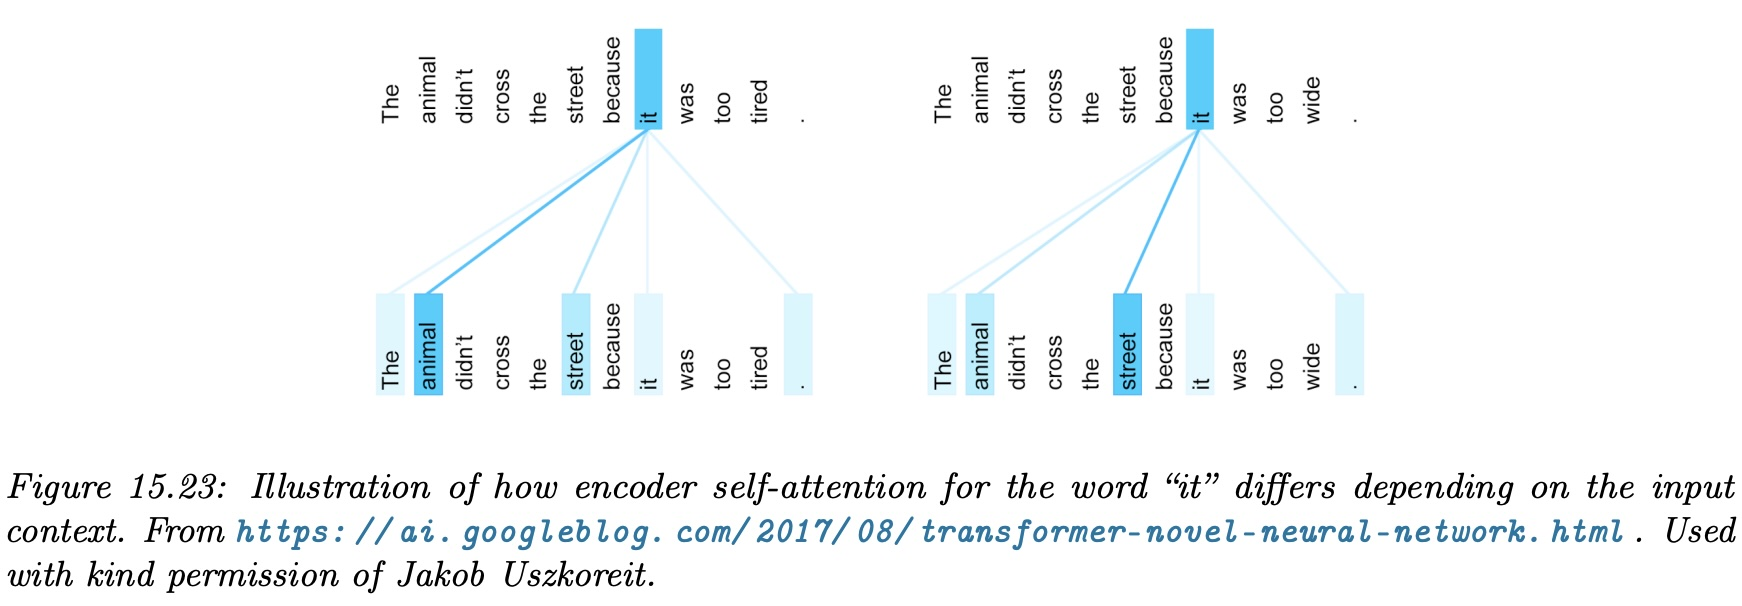

-   Attention lets one point of the input be strongly influenced by
    others in a context-dependent way
-   See the above, which associates the word “it” with “animal” when the
    pronoun needs to be interpreted in context

## Token Prediction

-   Recall with the ChatGPT style prediction of the next token, we need
    to find a
    ${\mathbb{P}\left( {x_t}\left| {x_{t-1}, x_{t-2}, \ldots, x_1} \right. \right)}$
    -   Where $t$ might be $1{-}2$ million or more, and there might be
        $100{,}000$ possible discrete $x_t$ values
-   Attention is central because it can find representations of the
    $x_{t-1}, x_{t-2}, \ldots, x_1$ for conditioning
    -   Self-attention makes it possible for the representations to
        capture the features of the joint distribution of previous
        tokens

# Example: Attention for Cross-Sectional Data

## Attention as Learned Peer Comparison

-   **Task**: predict each firm $i$’s next-quarter return $y_i$ using
    the cross-section of $n$ firms with features
    $x_i \in {\mathbb{R}}^h$ (size, leverage, sector, R&D, ROA)
-   **Without attention**: pick peers by SIC code, average their returns
    — a weighted average $\hat{y}(x) = \sum_i \alpha_i y_i$ where
    $\alpha_i \propto K(x, x_i)$ and $K$ is a fixed smoothing kernel
-   **With attention**: learn the similarity function, and what firm $i$
    considers “similar” can differ from what firm $j$ considers
    “similar”

## What the Projections Capture

-   **Task reminder**: predict firm $i$’s return using information
    gathered from other firms
-   $W_K x_j$ = firm $j$’s **profile**: how it presents itself to others
    (sector, size, growth characteristics)
-   $W_Q x_i$ = firm $i$’s **search criterion**: what features firm $i$
    looks for in peers to help predict *its own* return
-   $q_i \cdot k_j$ = how well firm $j$’s profile matches firm $i$’s
    search criterion → attention weight $\alpha_{ij}$
-   $W_V x_j$ = the **information** firm $j$ contributes (its return,
    transformed) — weighted by $\alpha_{ij}$ and summed
-   **Asymmetry from $W_Q \neq W_K$**: a startup searching for peers
    loads on “large, established, tech” → high
    $\alpha_{\text{startup},\text{Apple}}$. But Apple searching for
    peers loads on “mega-cap, global” → low
    $\alpha_{\text{Apple},\text{startup}}$. The attention weights are
    inherently directional

## Attention vs Self-Attention for Firms

-   **Cross-attention**: target portfolio firms query a separate
    reference universe to predict their returns. One-directional:
    targets search, references answer
-   **Self-attention**: all $n$ firms in one pool. Every firm
    simultaneously queries and is queried. Produces the full
    $n \times n$ peer-relevance network
-   Self-attention adds structure:
    -   Same $W_Q, W_K$ must work for every firm as both searcher and
        reference → learns *general* relevance, not ad-hoc pairings
    -   Asymmetric: $\alpha_{ij} \neq \alpha_{ji}$ — firm $i$ finding
        firm $j$ useful for prediction doesn’t imply the reverse
    -   **Stacked layers**: firm $i$’s representation is enriched by its
        peers, whose representations were enriched by *their* peers —
        captures indirect peer effects ($i \leftarrow j \leftarrow k$)
-   Progression: **fixed kernel** (manual SIC peers) → **attention**
    (learned one-directional lookup) → **self-attention** (learned,
    asymmetric, full peer network)

# The Transformer Block

## From Attention to Transformers

-   Attention is a **linear re-weighting** of values — powerful for
    routing information, but limited on its own
-   To build a full sequence model we need three additional ideas:
    1.  **Nonlinearity**: a feed-forward network (FFN) after attention
        to transform representations
    2.  **Gradient flow**: residual (skip) connections so gradients pass
        through 100+ layers
    3.  **Training stability**: layer normalization to keep activations
        well-scaled
-   Together with multi-head attention, these form the **transformer
    block** — the repeating unit of every modern LLM

## Feed-Forward Network (FFN)

-   Applied independently to each token after attention: $$
    \text{FFN}(z) = W_2\,\sigma(W_1 z + b_1) + b_2
    $$
    -   $W_1 \in {\mathbb{R}}^{d_{\text{ff}} \times d}$ with
        $d_{\text{ff}} \approx 4d$; $\sigma$ = ReLU or GELU (recall
        [Deep Learning lecture](deep_learning.qmd))
-   **Why is this needed?** Attention output is linear in $V$ — it
    routes information but doesn’t transform it
-   Intuition:
    -   Attention = “**communicate** between tokens”
    -   FFN = “**think** about what you heard”

## Residual Connections

-   An econometrician’s instinct: instead of modeling the level
    $z_{\text{out}} = f(z_{\text{in}})$ directly, model the **residual**
    $$
    z_{\text{out}} = z_{\text{in}} + f(z_{\text{in}})
    $$
    -   The network only needs to learn the **correction** $f$ — the
        deviation from the identity
    -   Easy to learn “do nothing” (set $f \approx 0$), hard to learn
        the identity with a general $f$
-   Gradient:
    $\frac{\partial z_{\text{out}}}{\partial z_{\text{in}}} = I + \frac{\partial f}{\partial z_{\text{in}}}$
    -   Even if $\frac{\partial f}{\partial z_{\text{in}}} \approx 0$,
        gradients still flow through $I$ — **prevents vanishing
        gradients** across 100+ layers
-   This is the **“Add”** in the “Add & Norm” boxes in the architecture
    diagram

## Why Layer Normalization?

$$
\text{LayerNorm}(z) = \gamma \odot \frac{z - \mu_z}{\sqrt{\sigma_z^2 + \epsilon}} + \beta
$$

-   An **engineering necessity** forced by finite-precision arithmetic
-   Through many layers, activations drift to very large or very small
    values
    -   Gradients accumulate numerical errors → training becomes
        unstable
    -   Normalization recenters activations into a well-behaved range
        after every sub-layer
-   Normalizes **across features** (per token), not across the batch
    -   Sequences have variable length → batch statistics are unreliable
        → LayerNorm over BatchNorm
-   This is the **“Norm”** in “Add & Norm”; $\gamma, \beta$ are
    learnable scale and shift

<figure>
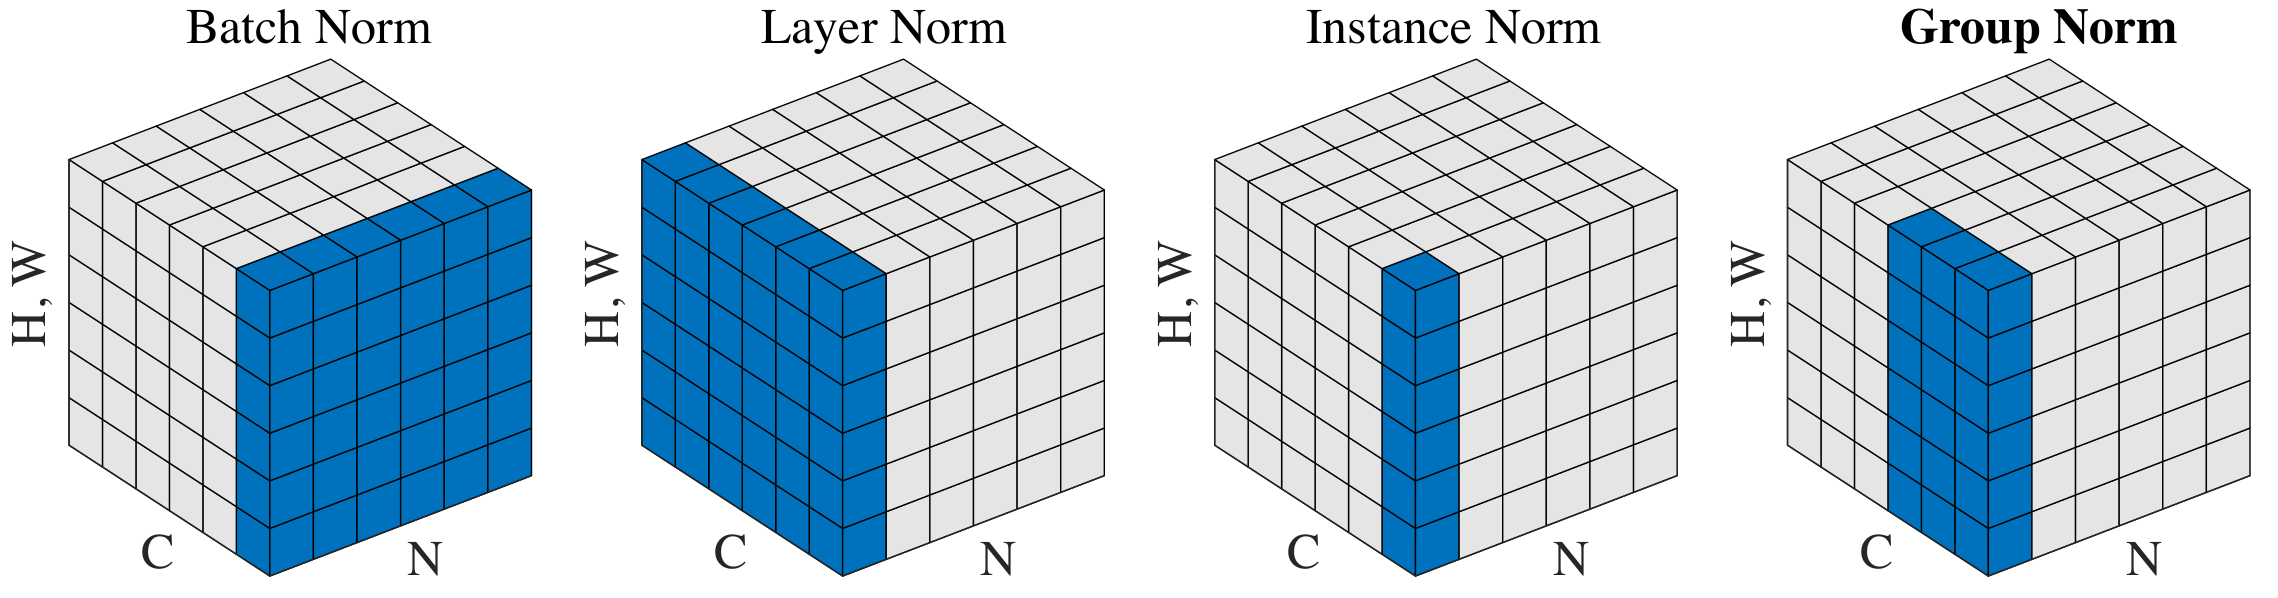
<figcaption aria-hidden="true">Comparison of normalization schemes (Wu
&amp; He 2018, ProbML Book 1 Fig 14.14)</figcaption>
</figure>

## The Transformer Block

$$
\begin{aligned}
z' &= \text{LayerNorm}\!\bigl(x + \text{MultiHead}(x)\bigr) \\
z_{\text{out}} &= \text{LayerNorm}\!\bigl(z' + \text{FFN}(z')\bigr)
\end{aligned}
$$

**Data flow** (one block):

Input → Multi-Head Attention → Add residual → LayerNorm → FFN → Add
residual → LayerNorm → Output

-   Stack $L$ identical blocks ($L = 12$ for BERT-base, $L \geq 96$ for
    GPT-4 class)
-   Each block has its own learned parameters
-   Dropout (not shown) is applied after attention and FFN for
    regularization

<figure>
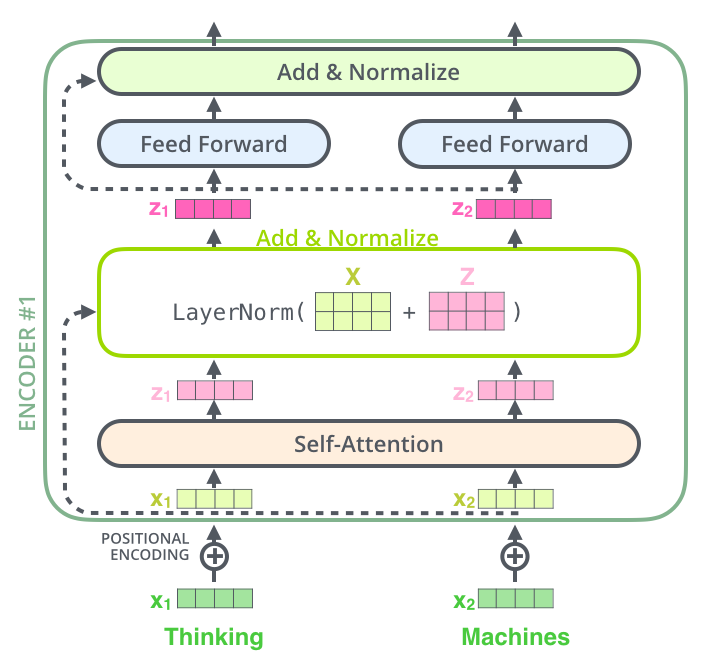
<figcaption aria-hidden="true">Single encoder block (Jay Alammar,
<em>The Illustrated Transformer</em>; cf. ProbML Book 2 Fig
16.15)</figcaption>
</figure>

## Why Causal Masking?

-   **Goal**: learn representations from raw text with **no labels**
    (self-supervised)
-   **Key idea**: use each sequence as its own training data — predict
    every next token from its history
-   The causal mask enforces this: $$
    \text{Attn}(Q, K, V) = \mathrm{softmax}\!\left(\frac{Q K^\top}{\sqrt{d}} + M\right) V
    $$ where $M_{ij} = 0$ if $i \geq j$, and $M_{ij} = -\infty$ if
    $i < j$
-   After softmax, $e^{-\infty} = 0$: token $i$ attends only to tokens
    $1, \ldots, i$
-   This is the **“Mask (opt.)”** in the architecture diagram
-   Enables **parallel training**: all positions are predicted
    simultaneously, each seeing only its past
-   Different masking strategies → different self-supervised objectives
    (e.g., BERT masks random tokens instead → bidirectional context)

<figure>
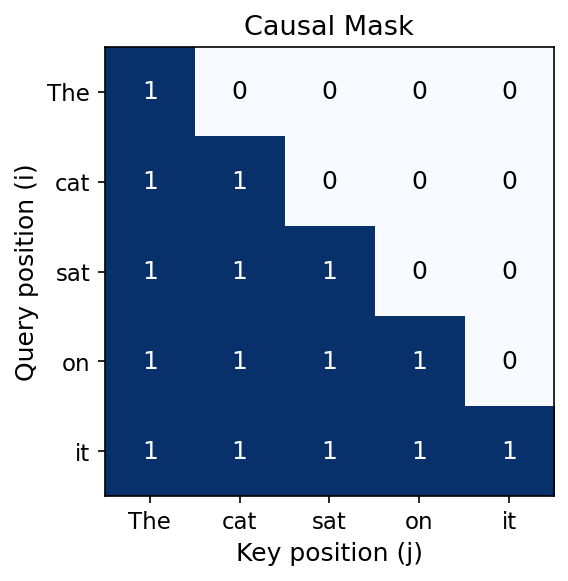
<figcaption aria-hidden="true">Lower-triangular causal mask: token <span
class="math inline"><em>i</em></span> can only attend to positions <span
class="math inline"> ≤ <em>i</em></span></figcaption>
</figure>

# Transformer Architectures

## Example Encoder-Decoder Transformer Architecture

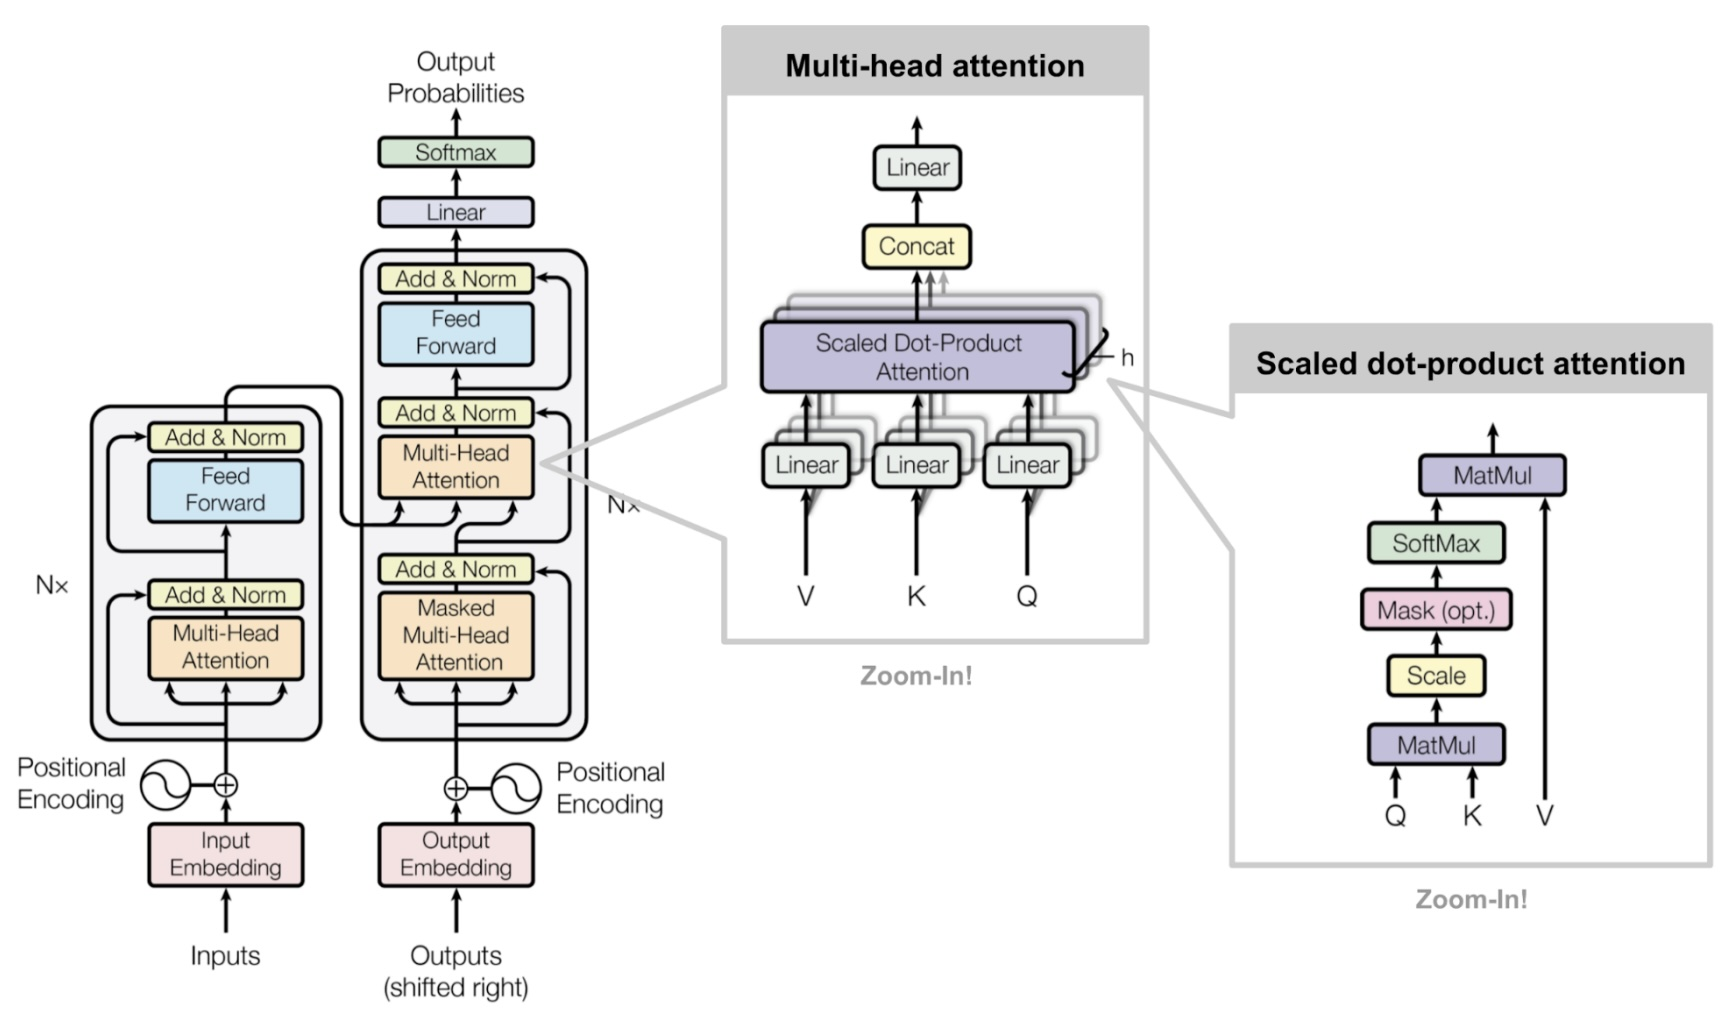

Students can now identify every component in this diagram: multi-head
attention, the “Add & Norm” blocks (residual connections + layer
normalization), the feed-forward networks, positional encoding, the
causal mask in the decoder, and the cross-attention block connecting
encoder to decoder.

## Sequence to Sequence

-   Early transformer designed for translation tasks (sequence of tokens
    as input to sequence of tokens as output)
    -   i.e., the
        ${\mathbb{P}\left( {y_1, \ldots, y_T}\left| {x_1, \ldots, x_T} \right. \right)}$
        where $T$ might be enormous, and $x,y$ might allow tens of
        thousands of tokens
-   The design of these typically uses a transformer to encode
    $x_1, \ldots, x_T$ into a representation, then another to decode,
    and take the representation back to the $y_1, \ldots, y_T$ tokens
-   **Encoder**: bidirectional self-attention (no mask) — every input
    token sees all others
-   **Decoder**: causal self-attention + **cross-attention** where $Q$
    comes from decoder, $K$ and $V$ from the encoder output
    -   This cross-attention is the middle attention block in the
        decoder stack (see diagram)

## Decoder-Only Transformer

-   To generate text token by token, as in sequential generation, we can
    use a single transformer
    -   i.e., the
        ${\mathbb{P}\left( {x_{T+1}}\left| {x_1, \ldots, x_T} \right. \right)}$
-   This is **GPT**, LLaMA, Claude, Gemini, and most modern LLMs
-   **Training**: predict every next token in parallel using causal
    masking (no future leakage)
    -   Trained with cross-entropy loss (MLE), exactly as in the
        [Embeddings lecture](embeddings_nlp_llm.qmd)
-   Simpler than encoder-decoder: no cross-attention needed, just
    stacked masked self-attention blocks
-   Scales well — architecture and data can grow together

## Encoder-Only Transformer

-   For tasks like classification, the transformer can be used to encode
    an internal representation of the input for a downstream task
    -   i.e., the
        ${\mathbb{P}\left( {\text{Class}(x_1, \ldots, x_T) = C_i}\left| {x_1, \ldots, x_T} \right. \right)}$
-   **Bidirectional** self-attention (no causal mask) — every token sees
    the full context
-   Self-supervised via **Masked Language Modeling (MLM)**: mask ~15% of
    tokens, predict them from context
    -   This is the `[MASK]` fill-in task and the word embeddings from
        the [Embeddings lecture](embeddings_nlp_llm.qmd)
-   **BERT** is the canonical example — now clear *why* it uses
    bidirectional attention: it needs context on **both sides** of each
    masked token
-   The final layer representation feeds into a classifier head for the
    downstream task

## Vision Transformers (ViT)

1.  Split the image into fixed-size **patches** (e.g., 16×16 pixels)
2.  Flatten each patch and linearly project to embedding dimension $d$
3.  Add learned **2D positional embeddings**
4.  Prepend a `[CLS]` token whose final representation is used for
    classification

-   Key insight: a transformer is a **general-purpose sequence
    processor**, not NLP-specific

<figure>
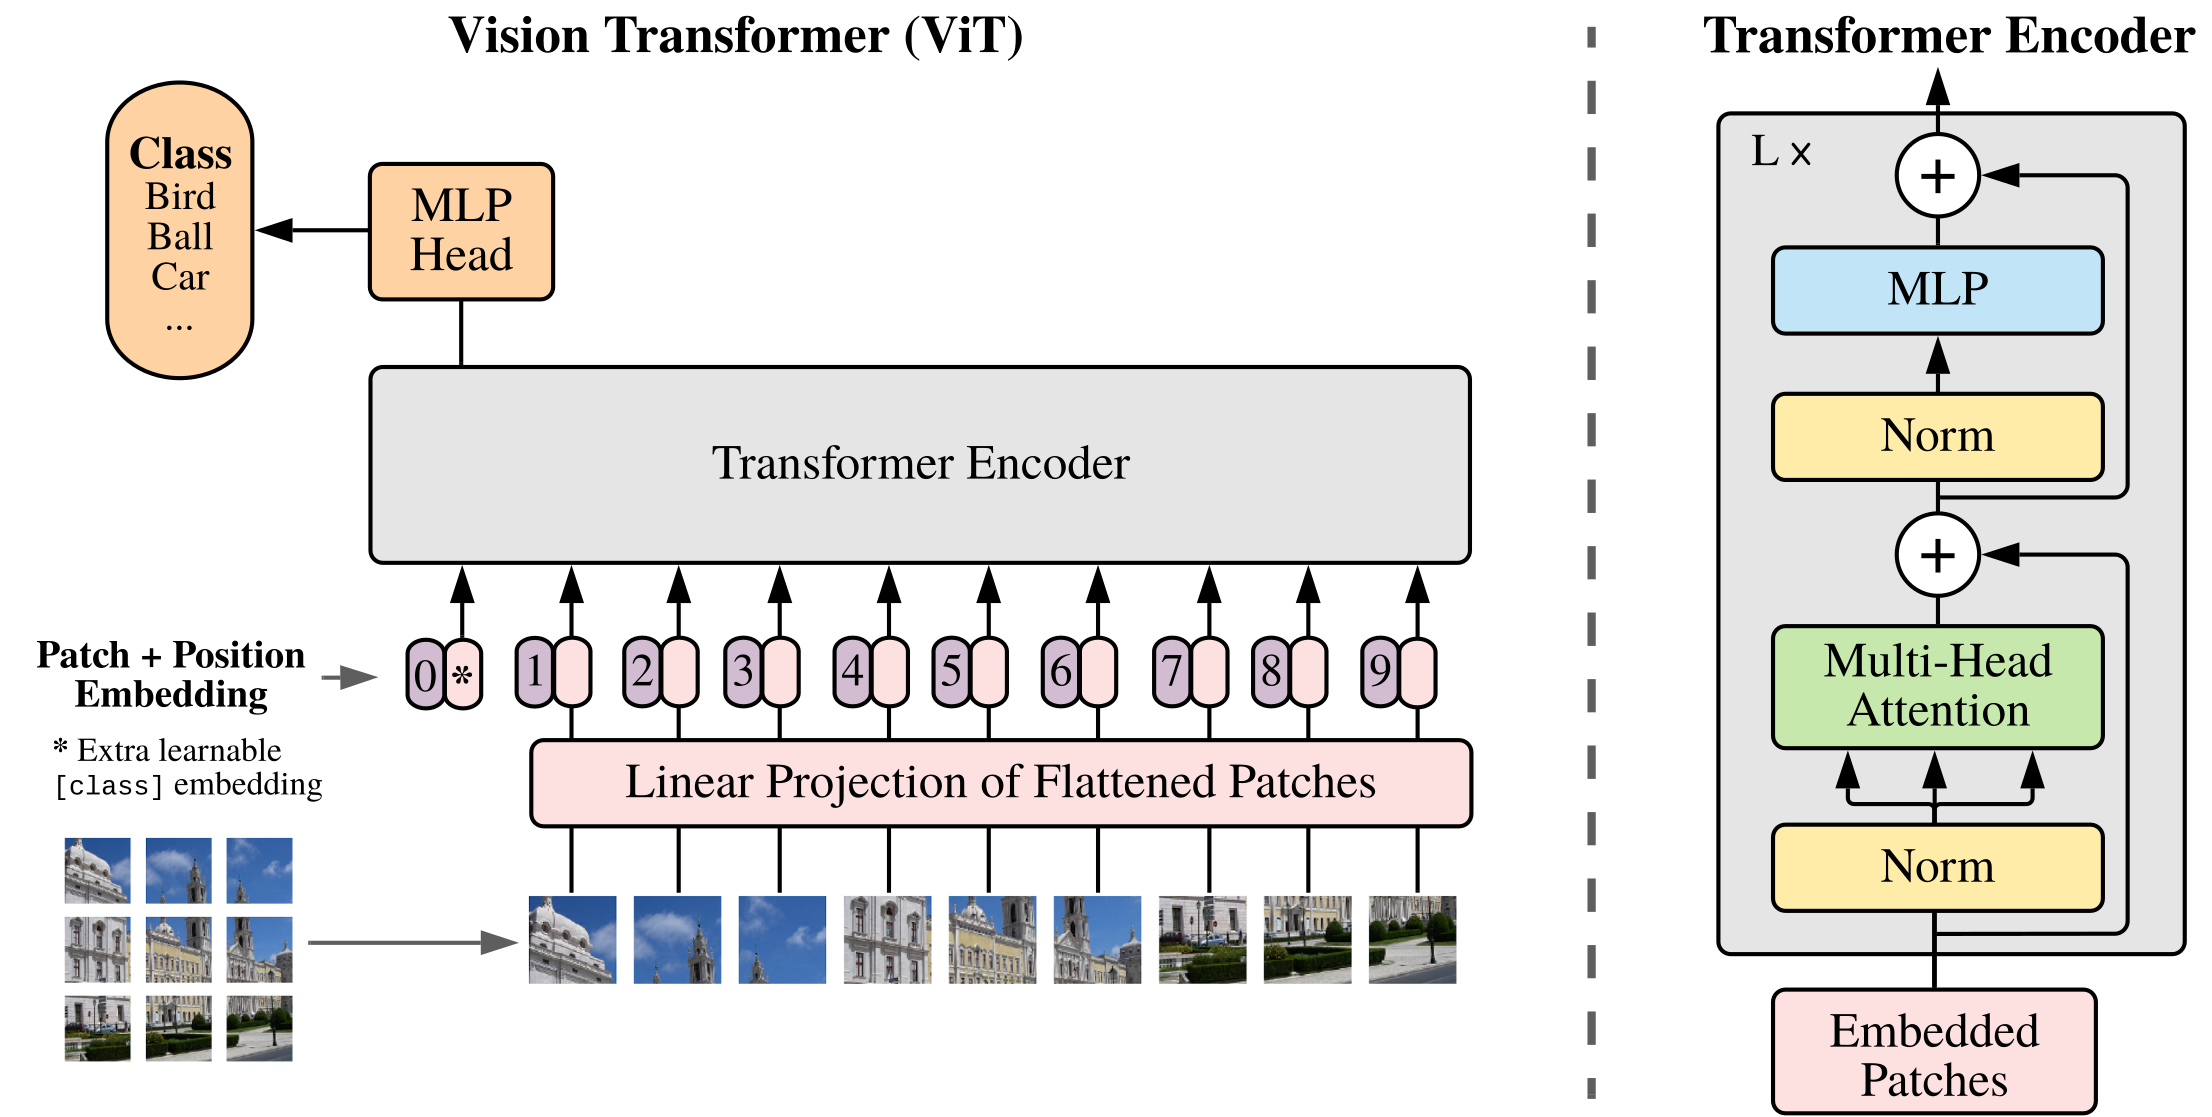
<figcaption aria-hidden="true">ViT architecture (Dosovitskiy et
al. 2020, ProbML Book 1 Fig 15.28)</figcaption>
</figure>

## Beyond Images and Text

-   The attention mechanism applies whenever **parts of the data should
    inform each other**
-   Examples beyond NLP and vision:
    -   **Graphs**: Graph Attention Networks (GATs) use attention over
        node neighbors
    -   **Time series**: temporal attention for forecasting and anomaly
        detection
    -   **Proteins**: AlphaFold uses attention over amino acid residues
        to predict 3D structure
-   General pattern: tokenize your domain → add appropriate positional
    info → apply transformer blocks